# Introduction
Hi! I am **Mark Wilson Mendoza**, and this project explores my **Spotify Streaming History** using **Python**.  
My goal is to uncover insights about my personal listening habits and practice querying data using **SQL**.  
The dataset comes from Spotify's Extended Streaming History, which you can request from their [Privacy Settings](https://www.spotify.com/us/account/privacy/).  
To get your own data:
1. Scroll to **Download your data** 
2. Tick the box for **Extended Streaming History**
3. Submit your request and wait for the download link via email (mine arrived after ~3 days)

The Spotify data includes both your audio and video streaming activity, along with a PDF file that describes the provided files.  
In this project, the dataset covers streams from **December 13, 2021 to June 18, 2025**  
**Here is an example of one song streaming data:**
![](images/song_stream_data.png)  
**The following table explains the technical data:**
![](images/column_description_0.png)
![](images/column_description_1.png)

Before the analysis, we need to install and import some essential libraries:
- warnings (optional) - suppress runtime warnings
- json - Load data from Spotify's JSON files
- pandas - Data wrangling and manipulation
- matplotlib - Static data visualization
- plotly - Interactive plots
- sqlalchemy and sqlite3 - Relational database and SQL integration

In [1]:
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3

pd.options.display.max_columns = 999
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

# Loading and Cleaning the Data
Since Spotify splits the extended streaming history into multiple JSON files, the first step is to load and combine them into a single dataset.  
We can then inspect the dataset and see the **column names**.

In [2]:
# Opens the JSON files and loads them into pandas DataFrames
with open("data/Streaming_History_Audio_2021-2024_0.json", encoding="utf-8") as a:
    a_data = json.load(a)

with open("data/Streaming_History_Audio_2024-2025_1.json", encoding="utf-8") as b:
    b_data = json.load(b)

with open("data/Streaming_History_Audio_2025_2.json", encoding="utf-8") as c:
    c_data = json.load(c)
    
a_data = pd.json_normalize(a_data)
b_data = pd.json_normalize(b_data) # Normalize the JSON data into a flat table
c_data = pd.json_normalize(c_data)

df = pd.concat([a_data, b_data, c_data], ignore_index=True) # Combines the DataFrames into one

In [3]:
# Explore the dataset shape
df.shape

(33306, 23)

In [4]:
# Display all columns
df.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')

The timestamps in the dataset are in UTC, so we need to convert them to **Philippine Time (UTC+8)** for a better time analysis.  
We also only focus on the most relevant columns and do other necessary cleaning:  
- time
- platform
- duration played
- song title
- artist name
- album name
- skipped status

In [5]:
# Select only the relevant columns
cleaned_df = df[["ts", "platform", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "skipped"]].copy()
cleaned_df.columns = ["time", "platform", "ms_played", "song", "artist", "album", "skipped"]

# Convert timezone
cleaned_df["time"] = pd.to_datetime(cleaned_df["time"], format="ISO8601", utc=True) # Converts the 'ts' column to datetime format
cleaned_df["time"] = cleaned_df["time"].dt.tz_convert("Asia/Manila") # Converts the timezone to Asia/Manila

cleaned_df.loc[df["platform"].str.contains("windows", case=False), "platform"] = "windows" # Makes sure all instances of each platform are the same
cleaned_df.loc[df["platform"].str.contains("android", case=False), "platform"] = "android"

cleaned_df = cleaned_df.dropna().reset_index() # Drops rows with any NaN values
cleaned_df.head(10)

,index,time,platform,ms_played,song,artist,album,skipped
0,0,2021-12-13 22:29:52+08:00,windows,198053,The Feels,TWICE,Formula of Love: O+T=<3,False
1,1,2021-12-13 22:33:07+08:00,windows,194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,False
2,2,2021-12-13 22:36:39+08:00,windows,210573,Alcohol-Free,TWICE,Taste of Love,False
3,3,2021-12-13 22:40:04+08:00,windows,205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,False
4,4,2021-12-13 22:44:04+08:00,windows,208240,What is Love,TWICE,Summer Nights,False
5,5,2021-12-13 22:47:38+08:00,windows,213880,FANCY,TWICE,FANCY YOU,False
6,6,2021-12-13 22:51:06+08:00,windows,206866,Feel Special,TWICE,Feel Special,False
7,7,2021-12-13 22:54:30+08:00,windows,204167,CRY FOR ME,TWICE,CRY FOR ME,False
8,8,2021-12-13 22:57:57+08:00,windows,176160,ICON,TWICE,Formula of Love: O+T=<3,False
9,9,2021-12-13 23:04:25+08:00,windows,219386,MOONLIGHT,TWICE,Formula of Love: O+T=<3,False


In [6]:
# Explore each columns' dtypes
cleaned_df.dtypes

index                              int64
time         datetime64[ns, Asia/Manila]
platform                          object
ms_played                          int64
song                              object
artist                            object
album                             object
skipped                             bool
dtype: object

# Top 10 Artists
Let's see which **artists** I listened to the most

In [7]:
top_artists = cleaned_df["artist"].value_counts().head(10) # Gets the top 10 artists
top_artists = top_artists.reset_index() # Resets the index for better readability
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
           artist  count
0     Cup of Joe   1675
1          TWICE   1585
2   Zack Tabudlo    907
3        Ben&Ben    904
4    The Ridleys    768
5            WWE    674
6           mrld    643
7           BUZZ    594
8  Martti Franca    586
9           BINI    574


**Cup of Joe** takes the top spot, followed by **TWICE**, both surpassed 1500 streams.

Below is a clear visualization of my **Top 10 most streamed artists**:

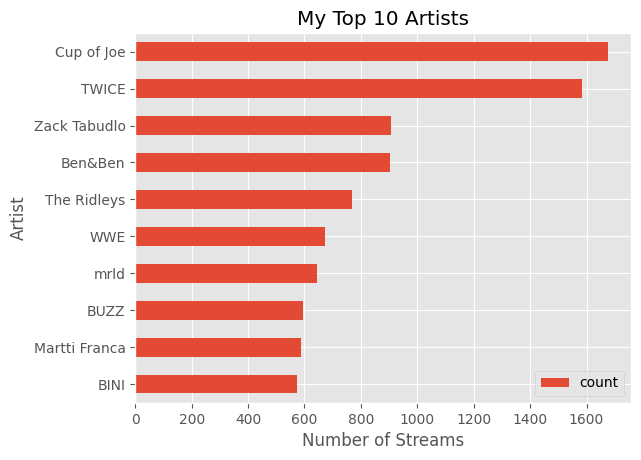

In [8]:
# Plots the top 10 artists using Matplotlib
ax = top_artists.sort_values(by="count", ascending=True).plot(kind="barh", x="artist", y="count", title="My Top 10 Artists")
ax.set_xlabel("Number of Streams")
ax.set_ylabel("Artist")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    top_artists,
    x=top_artists["count"].sort_values(ascending=True),
    y=top_artists["artist"].sort_index(ascending=False),
    title="My Top 10 Artists",
    labels={"x" : "Artist", "y" : "Number of Streams"},
    orientation="h"
)

fig.show()

This bar graph highlights the gap between the top two artists and the rest. It shows that **Cup of Joe** and **TWICE** dominated my listeing habits.

Now let's explore my **listening habits over time** for my two most streamed artists: Cup of Joe and TWICE.

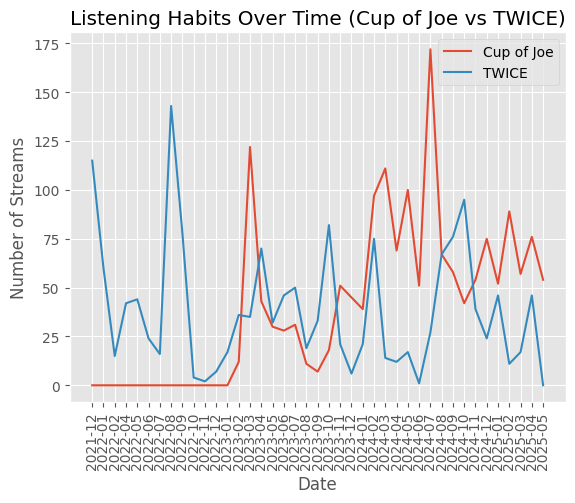

In [9]:
CoJ_streams = cleaned_df[cleaned_df["artist"] == "Cup of Joe"]
CoJ_streams["date"] = CoJ_streams["time"].dt.to_period("M").astype(str)
CoJ_counts = CoJ_streams["date"].value_counts().sort_index()

TW_streams = cleaned_df[cleaned_df["artist"] == "TWICE"]
TW_streams["date"] = TW_streams["time"].dt.to_period("M").astype(str)
TW_counts = TW_streams["date"].value_counts().sort_index()

all_dates = sorted(set(CoJ_counts.index).union(set(TW_counts.index)))

CoJ_aligned_dates = CoJ_counts.reindex(all_dates, fill_value=0).reset_index()
TW_aligned_dates = TW_counts.reindex(all_dates, fill_value=0).reset_index()

plt.plot(CoJ_aligned_dates["date"][:-1], CoJ_aligned_dates["count"][:-1], label="Cup of Joe")
plt.plot(TW_aligned_dates["date"][:-1], TW_aligned_dates["count"][:-1], label="TWICE")
plt.title("Listening Habits Over Time (Cup of Joe vs TWICE)")
plt.xlabel("Date")
plt.ylabel("Number of Streams")
plt.xticks(rotation=90)
plt.legend()
plt.show()

The line graph above compares their monthly stream counts, which highlights which artist I've listened to the most at different points in time.

# Top 10 Albums
Now, let's explore which **albums** I've listened to the most.

In [10]:
top_albums = cleaned_df["album"].value_counts()
top_albums = top_albums.reset_index()

# Get the artist for each album in top_albums
album_to_artist = cleaned_df.drop_duplicates(subset=["album"])[["artist", "album"]].set_index("album")["artist"]
top_albums["artist"] = top_albums["album"].map(album_to_artist)
top_albums = top_albums[["artist", "album", "count"]]
print("Top 10 Albums:\n", top_albums.head(10))

Top 10 Albums:
            artist                              album  count
0            Hale                               Hale    349
1     The Ridleys  Reflections on Moonlight & Poetry    301
2    Zack Tabudlo                 3rd Time’s A Charm    287
3      Cup of Joe                        Estranghero    272
4      Cup of Joe                       Patutunguhan    260
5    Zack Tabudlo                            Episode    260
6           TWICE                        BETWEEN 1&2    208
7      Bruno Mars               Doo-Wops & Hooligans    207
8  Unique Salonga                            Grandma    200
9    IV Of Spades                      CLAPCLAPCLAP!    198


Overall, **Hale (album)** by **Hale (artist)** is my most streamed album.  
Interestingly, both **Zack Tabudlo** and **Cup of Joe** appear twice in the top 10, this shows my music taste and go-to albums.

# Top 10 Songs
These are the songs I've listed to the most.

In [11]:
top_songs = cleaned_df["song"].value_counts()
top_songs = top_songs.reset_index()

song_to_artist = cleaned_df.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
top_songs["artist"] = top_songs["song"].map(song_to_artist)
top_songs = top_songs[["artist", "song", "count"]]
print("Top 10 Songs:\n", top_songs.head(10))

Top 10 Songs:
            artist                      song  count
0      Cup of Joe               Estranghero    272
1      Cup of Joe                Misteryoso    197
2      Cup of Joe                    Tingin    196
3  Up Dharma Down                   Tadhana    191
4      Cup of Joe                 Sinderela    176
5      Lola Amour                    Fallen    168
6            Maki                     Dilaw    167
7      Cup of Joe               Wag Na Lang    167
8            mrld               Ikaw Pa Rin    165
9   Martti Franca  Things She'll Never Know    163


**Cup of Joe** once again takes the top spot.  
They also appear **five times** in the Top 10.  
This proves why they're my most streamed artist.

# Top 10 Skipped Songs
Let's now look at my Top 10 skipped songs

In [12]:
skipped_songs = cleaned_df[cleaned_df["skipped"] == True]
skipped_song_counts = skipped_songs["song"].value_counts().head(10) # Gets the top 10 skipped songs
skipped_song_counts = skipped_song_counts.reset_index()

song_to_artist = skipped_songs.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
skipped_song_counts["artist"] = skipped_song_counts["song"].map(song_to_artist)
skipped_song_counts = skipped_song_counts[["artist", "song", "count"]]

print("Top 10 Skipped Songs:\n", skipped_song_counts.head(10))

Top 10 Skipped Songs:
              artist         song  count
0              Maki        Dilaw     77
1        Cup of Joe  Estranghero     70
2        Cup of Joe   Misteryoso     62
3        Cup of Joe       Tingin     62
4        Lola Amour       Fallen     51
5        Cup of Joe  Wag Na Lang     51
6  Healy After Dark         Isip     47
7    Up Dharma Down      Tadhana     46
8            NOBITA    Ikaw Lang     44
9              MKTO      Classic     43


The song **Dilaw** by **Maki** is at the top of my most skipped songs. 
But what's intersting about this is that some songs here also appear in my Top 10 most streamed songs.  
This might suggest that even though I stream these songs a lot, I also tend to skip them occasionally, maybe due to being overplayed.

# Database Integration
To prepare the dataset for SQL queries, we need to separate the data into:
- **Artists**
- **Albums**
- **Songs**  

The next few steps extract the unique values for each of the ones above.  
This step is needed in designing a relational database schema later on.

In [13]:
cleaned_df_copy = cleaned_df.copy() # Creates a copy of the cleaned DataFrame for further analysis

In [14]:
stream_history = cleaned_df.copy()
stream_history = stream_history.rename(columns={"index" : "stream_id"})
stream_history["stream_id"] = stream_history.index + 1
stream_history.head(10)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,1,2021-12-13 22:29:52+08:00,windows,198053,The Feels,TWICE,Formula of Love: O+T=<3,False
1,2,2021-12-13 22:33:07+08:00,windows,194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,False
2,3,2021-12-13 22:36:39+08:00,windows,210573,Alcohol-Free,TWICE,Taste of Love,False
3,4,2021-12-13 22:40:04+08:00,windows,205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,False
4,5,2021-12-13 22:44:04+08:00,windows,208240,What is Love,TWICE,Summer Nights,False
5,6,2021-12-13 22:47:38+08:00,windows,213880,FANCY,TWICE,FANCY YOU,False
6,7,2021-12-13 22:51:06+08:00,windows,206866,Feel Special,TWICE,Feel Special,False
7,8,2021-12-13 22:54:30+08:00,windows,204167,CRY FOR ME,TWICE,CRY FOR ME,False
8,9,2021-12-13 22:57:57+08:00,windows,176160,ICON,TWICE,Formula of Love: O+T=<3,False
9,10,2021-12-13 23:04:25+08:00,windows,219386,MOONLIGHT,TWICE,Formula of Love: O+T=<3,False


In [15]:
# Creates a DataFrame with unique artists and assigns a unique ID to each artist
streamed_artists = pd.DataFrame(cleaned_df_copy["artist"].unique(), columns=["artist"]) # Creates a DataFrame with unique artists
streamed_artists["artist_id"] = streamed_artists.index + 1 # Assigns a unique ID to each artist
streamed_artists = streamed_artists.iloc[:, [1, 0]] # Reorders the columns to have artist_id first
streamed_artists.head(10)

,artist_id,artist
0,1,TWICE
1,2,NiziU
2,3,J.Y. Park
3,4,(G)I-DLE
4,5,Stray Kids
5,6,GOT7
6,7,STAYC
7,8,K/DA
8,9,Seungmin
9,10,ITZY


In [16]:
# Creates a DataFrame with unique songs and assigns a unique ID to each song
streamed_music = pd.DataFrame(cleaned_df_copy["song"].unique(), columns=["song"]) # Creates a DataFrame with unique songs
streamed_music["song_id"] = streamed_music.index + 1 # Assigns a unique
streamed_music = streamed_music.iloc[:, [1, 0]] # Reorders the columns to have song_id first
streamed_music.head(10)

,song_id,song
0,1,The Feels
1,2,SCIENTIST
2,3,Alcohol-Free
3,4,I CAN'T STOP ME
4,5,What is Love
5,6,FANCY
6,7,Feel Special
7,8,CRY FOR ME
8,9,ICON
9,10,MOONLIGHT


In [17]:
# Creates a DataFrame with unique albums and assigns a unique ID to each album
streamed_albums = pd.DataFrame(cleaned_df_copy["album"].unique(), columns=["album"]) # Creates a DataFrame with unique albums
streamed_albums["album_id"] = streamed_albums.index + 1 # Assigns a unique ID to each album
streamed_albums = streamed_albums.iloc[:, [1, 0]] # Reorders the columns to have album_id first
streamed_albums.head(10)

,album_id,album
0,1,Formula of Love: O+T=<3
1,2,Taste of Love
2,3,Eyes Wide Open
3,4,Summer Nights
4,5,FANCY YOU
5,6,Feel Special
6,7,CRY FOR ME
7,8,Doughnut
8,9,Perfect World
9,10,Kura Kura


# Monthly Streaming Activity
Let's look at the change of my **overall listening activity** by month.

In [18]:
# Returns the number of streams per month
cleaned_df_copy["month"] = cleaned_df_copy["time"].dt.month
monthly_counts = cleaned_df_copy["month"].value_counts().sort_index() # Counts the number of streams per month
monthly_df = monthly_counts.reset_index()
monthly_df.head()

,month,count
0,1,2223
1,2,3549
2,3,3955
3,4,3540
4,5,3840


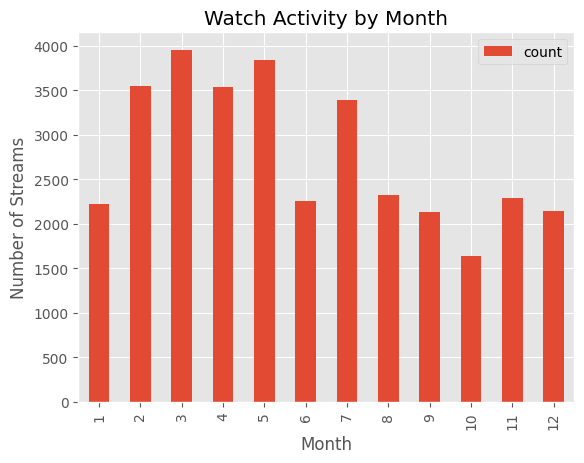

In [19]:
# Use Matplotlib to plot the all-time streams by month
monthly_df.plot(kind="bar", x="month", y="count")
plt.title("Watch Activity by Month")
plt.xlabel("Month")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    monthly_df,
    x="month",
    y="count",
    title="Watch Activity by Month",
    labels={"month": "Month", "count": "Number of Streams"}
)

fig.show()

The chart shows that **March** has the highest stream counts across the dataset.  
But is that a consistent pattern across years? Or maybe there is a single March that I streamed the most?

# Stream Over Time (Monthly)
Let's zoom in further and explore my **streams over time**.

In [20]:
# Returns the number of streams per month and year
cleaned_df_copy["month_year"] = cleaned_df_copy["time"].dt.to_period("M").astype(str) # Creates a new column for month and year
month_year_counts = cleaned_df_copy["month_year"].value_counts().sort_index() # Counts the number of streams per month and year
month_year_df = month_year_counts.reset_index()
month_year_df.head(10)

,month_year,count
0,2021-12,164
1,2022-01,284
2,2022-02,341
3,2022-03,99
4,2022-04,167
5,2022-05,519
6,2022-06,403
7,2022-07,274
8,2022-08,516
9,2022-09,584


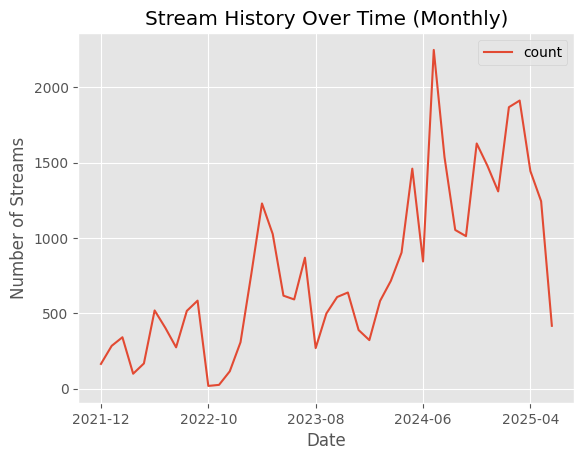

In [21]:
# Use Matplotlib to plot the all-time streams by month and year
month_year_df.plot(kind="line", x="month_year", y="count")
plt.title("Stream History Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.line(
    month_year_df[:-1],
    x="month_year",
    y="count",
    title="Stream History Over Time (Monthly)",
    labels={"month_year" : "Date", "count" : "Number of Streams"},
    markers=True
)

fig.show()

Surprisingly, even though March has the highest overall streams, the **single most active** month was in **July 2024**.  
This deeper breakdown conveys more insight into specific period of streaming.

# Hourly Streaming Activity
Now that we've seen how much I listen to music, let's explore when I'm most active.

In [22]:
# Returns the number of streams per hour
cleaned_df_copy["hour"] = cleaned_df_copy["time"].dt.hour
hourly_counts = cleaned_df_copy["hour"].value_counts().sort_index() # Counts the number of streams per hour
hourly_df = hourly_counts.reset_index()
hourly_df.head()

,hour,count
0,0,162
1,1,38
2,2,9
3,3,5
4,4,15


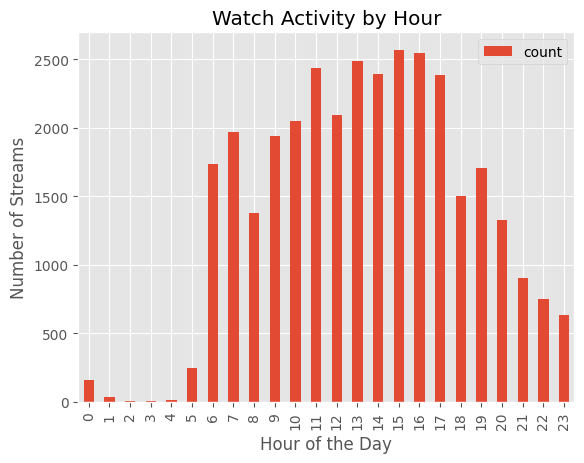

In [23]:
# Use Matplotlib to plot the all-time streams by hour
hourly_df.plot(kind="bar", x="hour", y="count")
plt.title("Watch Activity by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    hourly_df,
    x="hour",
    y="count",
    title="Watch Activity by Hour",
    labels={"hour" : "Hour of Day", "count" : "Number of Streams"}
)
fig.show()

The graph above shows that my **peak listening hours** are between **11AM and 5PM**, probably during work or study hours.

# Saving to a Database
Next, we store our structured data into an **SQLite database**.
The following tables were created for future SQL analysis:
- `streaming_history` - Main streaming data
- `streamed_artists` - Unique list of artists
- `streamed_music` - Unique list of tracks
- `streamed_albums` - Unique list of albums

In [24]:
# Creates a SQLite database and saves the cleaned DataFrame and the streamed artists, music, and albums to it
engine = create_engine("sqlite:///exported/streaming_history.db") # Creates a SQLite database
stream_history.to_sql("streaming_history", con=engine, if_exists="replace", index=False) # Saves the cleaned DataFrame to the database
streamed_artists.to_sql("streamed_artists", con=engine, if_exists="replace", index=False) # Saves the streamed artists to the database
streamed_music.to_sql("streamed_music", con=engine, if_exists="replace", index=False) # Saves the streamed music to the database
streamed_albums.to_sql("streamed_albums", con=engine, if_exists="replace", index=False) # Saves the streamed albums to the database

2583

# SQL Queries
Since **Cup of Joe** was one of my most streamed artists, here is a sample query to fetch all streams from therm.

In [25]:
# Sample query to fetch data from the SQLite database
conn = sqlite3.connect("exported/streaming_history.db") # Connects to the SQLite database
query = """
        SELECT * 
        FROM streaming_history
        WHERE artist = "Cup of Joe"
        LIMIT 10;
        """
df = pd.read_sql_query(query, conn)
print(df)

conn.close() # Closes the database connection

   stream_id                        time platform  ms_played  \
0       4382  2023-02-26 09:07:32.000000  windows     186584   
1       4384  2023-02-26 09:10:42.000000  windows     186471   
2       4385  2023-02-26 09:15:28.000000  windows     252459   
3       4386  2023-02-26 09:15:29.000000  windows        541   
4       4387  2023-02-26 09:18:36.000000  windows     186564   
5       4388  2023-02-26 09:20:20.000000  windows     103764   
6       4389  2023-02-26 09:28:16.000000  windows     475156   
7       4390  2023-02-26 09:32:38.000000  windows     261957   
8       4391  2023-02-26 09:35:32.000000  windows     149619   
9       4516  2023-02-28 06:04:01.000000  android     183524   

                          song      artist                        album  \
0                  Estranghero  Cup of Joe                  Estranghero   
1                  Estranghero  Cup of Joe                  Estranghero   
2  Ikaw Pa Rin Ang Pipiliin Ko  Cup of Joe  Ikaw Pa Rin Ang Pipiliin K

This query returns the **first 10** times I streamed a song by Cup of Joe, along with other details.

Here are more sample queries:
1. Get the first 10 rows of the `streaming_history` table.
2. Show all songs with a play duration longer than 180 seconds.
3. Find all streams where the song was not skipped.
4. Get the total number of rows in the `streaming_history`
5. Find all streams from Cup of Joe.
6. Find all albums you've streamed by TWICE.
7. List all streams that happened in 2023.
8. Show all songs streamed from mobile platform only.
9. Count how many songs were streamed in total.
10. Find the number of songs streamed per year.
11. Count how many songs you streamed per artist.
12. Which artist has the most streams?
13. Which album was skipped the most?
14. For each stream, show the artist name and album name.
15. Show the total number of streams per album, along with artist names.
16. Get the top 5 most streamed songs, with their artist names.
17. Show all songs streamed more than 10 times.
18. Number of songs streamed per weekday.
19. Peak hour of streaming activity.
20. Most active streaming day of all time.

In [26]:
def stream_query(query : str) -> pd.DataFrame:
    """
    Executes an SQL query and returns the results as a DataFrame.
    
    Parameters:
    query (str): The SQL query to execute.
    
    Returns:
    pd.DataFrame: The results of the query as a DataFrame.
    """
    conn = sqlite3.connect("exported/streaming_history.db") # Connects to the SQLite database
    df = pd.read_sql_query(query, conn) # Executes the query and returns the results as a DataFrame
    conn.close() # Closes the database connection
    return df

In [27]:
# 1. Get the first 10 rows of the `streaming_history` table.
query = """
        SELECT *
        FROM streaming_history
        LIMIT 10;
        """ 

stream_query(query)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,1,2021-12-13 22:29:52.000000,windows,198053,The Feels,TWICE,Formula of Love: O+T=<3,0
1,2,2021-12-13 22:33:07.000000,windows,194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,0
2,3,2021-12-13 22:36:39.000000,windows,210573,Alcohol-Free,TWICE,Taste of Love,0
3,4,2021-12-13 22:40:04.000000,windows,205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,0
4,5,2021-12-13 22:44:04.000000,windows,208240,What is Love,TWICE,Summer Nights,0
5,6,2021-12-13 22:47:38.000000,windows,213880,FANCY,TWICE,FANCY YOU,0
6,7,2021-12-13 22:51:06.000000,windows,206866,Feel Special,TWICE,Feel Special,0
7,8,2021-12-13 22:54:30.000000,windows,204167,CRY FOR ME,TWICE,CRY FOR ME,0
8,9,2021-12-13 22:57:57.000000,windows,176160,ICON,TWICE,Formula of Love: O+T=<3,0
9,10,2021-12-13 23:04:25.000000,windows,219386,MOONLIGHT,TWICE,Formula of Love: O+T=<3,0


In [28]:
# 2. Show all songs with a play duration longer than 180 seconds.
query = """
        SELECT *
        FROM streaming_history
        WHERE ms_played > 180000;
        """

stream_query(query)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,1,2021-12-13 22:29:52.000000,windows,198053,The Feels,TWICE,Formula of Love: O+T=<3,0
1,2,2021-12-13 22:33:07.000000,windows,194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,0
2,3,2021-12-13 22:36:39.000000,windows,210573,Alcohol-Free,TWICE,Taste of Love,0
3,4,2021-12-13 22:40:04.000000,windows,205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,0
4,5,2021-12-13 22:44:04.000000,windows,208240,What is Love,TWICE,Summer Nights,0
...,...,...,...,...,...,...,...,...
17808,33283,2025-06-18 16:48:10.000000,windows,194453,One Call Away,Charlie Puth,Nine Track Mind,0
17809,33284,2025-06-18 16:51:45.000000,windows,213826,When I Was Your Man,Bruno Mars,Unorthodox Jukebox,0
17810,33285,2025-06-18 16:55:13.000000,windows,186986,2002,Anne-Marie,Speak Your Mind,0
17811,33286,2025-06-18 16:59:20.000000,windows,246410,Thinking Of You,Katy Perry,One Of The Boys,0


In [29]:
# 3. Find all streams where the song was not skipped.
query = """
        SELECT *
        FROM streaming_history
        WHERE skipped = 0;
        """

stream_query(query)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,1,2021-12-13 22:29:52.000000,windows,198053,The Feels,TWICE,Formula of Love: O+T=<3,0
1,2,2021-12-13 22:33:07.000000,windows,194600,SCIENTIST,TWICE,Formula of Love: O+T=<3,0
2,3,2021-12-13 22:36:39.000000,windows,210573,Alcohol-Free,TWICE,Taste of Love,0
3,4,2021-12-13 22:40:04.000000,windows,205493,I CAN'T STOP ME,TWICE,Eyes Wide Open,0
4,5,2021-12-13 22:44:04.000000,windows,208240,What is Love,TWICE,Summer Nights,0
...,...,...,...,...,...,...,...,...
22917,33283,2025-06-18 16:48:10.000000,windows,194453,One Call Away,Charlie Puth,Nine Track Mind,0
22918,33284,2025-06-18 16:51:45.000000,windows,213826,When I Was Your Man,Bruno Mars,Unorthodox Jukebox,0
22919,33285,2025-06-18 16:55:13.000000,windows,186986,2002,Anne-Marie,Speak Your Mind,0
22920,33286,2025-06-18 16:59:20.000000,windows,246410,Thinking Of You,Katy Perry,One Of The Boys,0


In [30]:
# 4. Get the total number of rows in the `streaming_history`
query = """
        SELECT COUNT(*) AS total_rows
        FROM streaming_history;
        """

stream_query(query)

,total_rows
0,33287


In [31]:
# 5. Find all streams from Cup of Joe.
query = """
        SELECT *
        FROM streaming_history
        WHERE artist = "Cup of Joe";
        """

stream_query(query)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,4382,2023-02-26 09:07:32.000000,windows,186584,Estranghero,Cup of Joe,Estranghero,0
1,4384,2023-02-26 09:10:42.000000,windows,186471,Estranghero,Cup of Joe,Estranghero,0
2,4385,2023-02-26 09:15:28.000000,windows,252459,Ikaw Pa Rin Ang Pipiliin Ko,Cup of Joe,Ikaw Pa Rin Ang Pipiliin Ko,1
3,4386,2023-02-26 09:15:29.000000,windows,541,Estranghero,Cup of Joe,Estranghero,1
4,4387,2023-02-26 09:18:36.000000,windows,186564,Estranghero,Cup of Joe,Estranghero,0
...,...,...,...,...,...,...,...,...
1670,33147,2025-06-12 15:51:00.000000,windows,222298,Tingin,Cup of Joe,Tingin,0
1671,33162,2025-06-12 18:14:50.000000,windows,262068,Ikaw Pa Rin Ang Pipiliin Ko,Cup of Joe,Ikaw Pa Rin Ang Pipiliin Ko,0
1672,33183,2025-06-16 05:59:03.000000,android,170898,Misteryoso,Cup of Joe,Misteryoso,1
1673,33185,2025-06-16 05:59:05.000000,android,610,Multo,Cup of Joe,Silakbo,1


In [32]:
# 6. Find all albums you've streamed by TWICE.
query = """
        SELECT DISTINCT album
        FROM streaming_history
        WHERE artist = "TWICE";
        """

stream_query(query)

,album
0,Formula of Love: O+T=<3
1,Taste of Love
2,Eyes Wide Open
3,Summer Nights
4,FANCY YOU
5,Feel Special
6,CRY FOR ME
7,Doughnut
8,Perfect World
9,Kura Kura


In [33]:
# 7. List all streams that happened in 2023.
query = """
        SELECT *
        FROM streaming_history
        WHERE time BETWEEN "2023-01-01 00:00:00" AND "2023-12-31 23:59:59";
        """

stream_query(query)

,stream_id,time,platform,ms_played,song,artist,album,skipped
0,3510,2023-01-04 08:11:20.000000,windows,194314,Pangarap Lang Kita,Parokya Ni Edgar,Middle-Aged Juvenile Novelty Pop Rockers,0
1,3511,2023-01-04 08:14:12.000000,windows,171464,Lifetime,Ben&Ben,Lifetime,0
2,3512,2023-01-04 08:19:16.000000,windows,303853,Eroplanong Papel,December Avenue,December Avenue,0
3,3513,2023-01-04 08:22:10.000000,windows,173865,Born To Win,BINI,Born To Win,0
4,3514,2023-01-04 08:23:18.000000,windows,5823,DJ Bumbay,Michael v,The Bubble G Anthology,1
...,...,...,...,...,...,...,...,...
7797,11307,2023-12-30 21:26:19.000000,android,193246,Just Because,mrld,Just Because,0
7798,11308,2023-12-30 21:26:56.000000,android,36469,Fallen,Lola Amour,Fallen,1
7799,11309,2023-12-30 21:29:06.000000,android,130011,I Really Like You,reon,I Really Like You,0
7800,11310,2023-12-30 21:41:46.000000,android,157871,Just Because,mrld,Just Because,0


In [34]:
# 8. Show all songs streamed from mobile platform only.
query = """
        SELECT song
        FROM streaming_history
        WHERE platform LIKE '%android%';
        """

stream_query(query)

,song
0,I should not have loved you
1,Missing You
2,My Love - Acoustic
3,잘 살아요
4,겁쟁이
...,...
20770,Isa lang
20771,TAKE ALL THE LOVE
20772,Nangangamba
20773,Misteryoso


In [35]:
# 9. Count how many songs were streamed in total.
query = """
        SELECT COUNT(DISTINCT song) AS total_songs
        FROM streaming_history;
        """

stream_query(query)

,total_songs
0,3549


In [36]:
# 10. Find the number of songs streamed per year.
query = """
        SELECT strftime('%Y', time) AS year, COUNT(*) AS total_streams
        FROM streaming_history
        GROUP BY year
        ORDER BY year;
        """

stream_query(query)

,year,total_streams
0,2021,164
1,2022,3345
2,2023,7802
3,2024,13782
4,2025,8194


In [37]:
# 11. Count how many songs you streamed per artist.
query = """
        SELECT artist, COUNT(*) as streams
        FROM streaming_history
        GROUP BY artist;
        """

stream_query(query)

,artist,streams
0,(G)I-DLE,35
1,*NSYNC,29
2,10CM,2
3,12th Street,5
4,1:43,9
...,...,...
1239,에이 스타일,1
1240,일기예보,1
1241,조유진,2
1242,차태현 Cha TaeHyun,3


In [38]:
# 12. Which artist has the most streams?
query = """
        SELECT artist, COUNT(*) as streams
        FROM streaming_history
        GROUP BY artist
        ORDER BY streams DESC
        LIMIT 1;
        """

stream_query(query)

,artist,streams
0,Cup of Joe,1675


In [39]:
# 13. Which album was skipped the most?
query = """
        SELECT album, COUNT(*) as skips
        FROM streaming_history
        WHERE skipped = 1
        GROUP BY album
        ORDER BY skips DESC
        LIMIT 1;
        """

stream_query(query)

,album,skips
0,Reflections on Moonlight & Poetry,92


In [40]:
# 14. For each stream, show the artist name and album name.
query = """
        SELECT artist, album
        FROM streaming_history;
        """

stream_query(query)

,artist,album
0,TWICE,Formula of Love: O+T=<3
1,TWICE,Formula of Love: O+T=<3
2,TWICE,Taste of Love
3,TWICE,Eyes Wide Open
4,TWICE,Summer Nights
...,...,...
33282,Charlie Puth,Nine Track Mind
33283,Bruno Mars,Unorthodox Jukebox
33284,Anne-Marie,Speak Your Mind
33285,Katy Perry,One Of The Boys


In [41]:
# 15. Show the total number of streams per album, along with artist names.
query = """
        SELECT album, artist, COUNT(*) AS streams
        FROM streaming_history
        GROUP BY album, artist;
        """

stream_query(query)

,album,artist,streams
0,#3 Deluxe Version,The Script,5
1,#TWICE,TWICE,3
2,#TWICE2,TWICE,3
3,#TWICE3,TWICE,1
4,#TWICE4,TWICE,2
...,...,...,...
2627,인기가요 뮤직크러쉬 Pt. 1 - 내가 예뻐진 이유,Ben,6
2628,정인 Jung In from Andromeda,Jung In,1
2629,투유 프로젝트 - 슈가맨 Pt.11,JIHYO,14
2630,포지션 스페셜 I LOVE YOU,Position,1


In [42]:
# 16. Get the top 5 most streamed songs, with their artist names.
query = """
        SELECT artist, song, COUNT(*) as streams
        FROM streaming_history
        GROUP BY artist, song
        ORDER BY streams DESC
        LIMIT 5;
        """

stream_query(query)

,artist,song,streams
0,Cup of Joe,Estranghero,272
1,Cup of Joe,Tingin,196
2,Cup of Joe,Misteryoso,192
3,Up Dharma Down,Tadhana,191
4,Cup of Joe,Sinderela,176


In [43]:
# 17. Show all songs streamed more than 10 times.
query = """
        SELECT song, COUNT(*) as streams
        FROM streaming_history
        GROUP BY song
        HAVING streams > 10;
        """

stream_query(query)

,song,streams
0,'Cause You Have To,11
1,"10,000 Hours (with Justin Bieber)",18
2,12:51,28
3,13,29
4,18,28
...,...,...
669,남자를 몰라,21
670,남자를 몰라 - Live,29
671,당돌한 여자,14
672,비망록 (스물의 노래),12


In [44]:
# 18. Number of songs streamed per weekday.
query = """
        SELECT strftime('%w', time) AS weekday, COUNT(*) AS total_streams
        FROM streaming_history
        GROUP BY weekday;
        """

stream_query(query)

,weekday,total_streams
0,0,4369
1,1,4918
2,2,4716
3,3,4909
4,4,5212
5,5,5152
6,6,4011


In [45]:
# 19. Peak hour of streaming activity.
query = """
        SELECT strftime('%H', time) AS hour, COUNT(*) AS total_streams
        FROM streaming_history
        GROUP BY hour;
        """

stream_query(query)

,hour,total_streams
0,00,162
1,01,38
2,02,9
3,03,5
4,04,15
5,05,251
6,06,1733
7,07,1967
8,08,1379
9,09,1943


In [46]:
# 20. Most active streaming day of all time.
query = """
        SELECT strftime('%Y-%m-%d', time) AS date, COUNT(*) as total_streams
        FROM streaming_history
        GROUP BY date
        ORDER BY total_streams DESC
        LIMIT 1;
        """

stream_query(query)

,date,total_streams
0,2024-07-31,276
